# Ground Motion Displacement RMS vs Time

*an example simple tutorial for getting seismic data, computing the power spectral densities, extracting the RMS and plotting*

Required:

- python
- obspy (and its dependencies)
- pandas
- jupyter
- notebook

this should be easy to set up in a conda env: ``conda create -n covid python=3.7 obspy pandas jupyter notebook``

Author: Thomas Lecocq @seismotom, Fred Massin @fmassin

## Step 1: imports

In [1]:
import datetime
import os
import glob
import sqlx2drms,imp


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
import numpy as np
import pandas as pd

from obspy import UTCDateTime, read
from obspy.core.stream import Stream
from obspy.clients.fdsn import Client
from obspy.signal import PPSD


## Step 2: Define Start/End dates and Seismic Channel

You'll have to make sure the seed_id you request is indeed available from the ``data_provider``

In [34]:
start = UTCDateTime("2020-03-08")
end = UTCDateTime() # means "now"

network = "CH"
station = "SBERN"#,SZUZ,SGEV,SLOP,SUSI,SEPFL,SBAM2" # Urban stations
location = ""
channel = "HGZ,HGE,HGN"
dataset = 'seismoRMSdata/urban-'

data_provider = "ETH"
logo = plt.imread('https://upload.wikimedia.org/wikipedia/commons/thumb/4/44/Logo_SED_2014.png/220px-Logo_SED_2014.png')
bans = {"2020-03-13":'Groups >100 banned', 
        "2020-03-20":'Groups >5 banned'}


## Step 2: Process PSDs to extract the RMS(displacement)

This can be done for multiple filters at once (``freqs`` below):

In [35]:
imp.reload(sqlx2drms)
test=sqlx2drms.sqlx2drms('pqlx@sqlx.ethz.ch',
                         network=network,
                         station=station,
                         location=location,
                         channel=channel,
                         start=start,
                         end=end)

In [36]:
imp.reload(sqlx2drms)
test=sqlx2drms.PSDs(test.count,
                    test.psd,
                    test.per,
                    test.times,
                    test.mseedids)
# Define frequency bands of interest:
freqs = [(0.1,1.0),(1.0,20.0),(4.0,14.0),(4.0,20.0)]
test.dRMS(freqs)

## Step 3: Custom plot for a single frequency band:

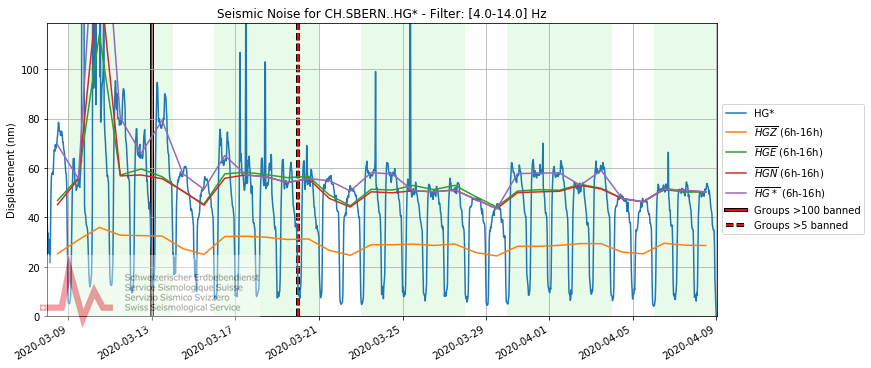

In [37]:
band = "4.0-14.0"
displacement_RMS=test.displacement_RMS

for channelcode in list(set([k[:-1] for k in displacement_RMS])):
    fig = plt.figure(figsize=(12,6))
    if logo is not None:
        fig.figimage(logo, 40, 40, alpha=.4, zorder=1)
    
    data={}
    for o in 'ZEN':
        if channelcode+o not in displacement_RMS :
            continue
        data[channelcode[-2:]+o] = displacement_RMS[channelcode+o][band]
        main=channelcode[-2:]+o
        
    if len(data.keys())>1:
        data[channelcode[-2:]+'*'] = data[main].copy() # for the sum
        main=channelcode[-2:]+'*'
        for i,t in enumerate(data[main].index):        
            data[main][i] = 0
            for o in data:
                if o == main:
                    continue
                if len(data[o].index)-1<i:
                    break
                if abs(data[o].index[i].timestamp()-data[main].index[i].timestamp())<60:
                    data[main][i] += data[o][i]**2
            data[main][i] = data[main][i]**.5
    
    plt.plot(data[main].index, data[main], label = main)
    
    for o in data:
        rs = data[o].copy().between_time("6:00", "16:00")
        rs = rs.resample("1D" ).median().tshift(12, "H")
        plt.plot(rs.index, rs, 
                 label="$\overline{%s}$ (6h-16h)"%o)#, c='purple')

    

    # Get normal business days and set their background color to green
    db = pd.bdate_range(start.datetime, end.datetime)
    for dbi in db:
        plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                    facecolor='lightgreen', edgecolor="none",
                    alpha=0.2, zorder=-10)

    scale = 1e9
    plt.ylim(0,np.nanpercentile(data[main],95)*1.5)
    ticks = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x*scale))
    plt.gca().yaxis.set_major_formatter(ticks)
    plt.ylabel("Displacement (nm)")

    plt.title('Seismic Noise for %s - Filter: [%s] Hz' % (channelcode[:]+main[-1],
                                                          band))
    plt.xlim(data[main].index.min(), data[main].index.max())
    fig.autofmt_xdate()
    plt.grid(True, zorder=-1)
    plt.gca().set_axisbelow(True)    
    for iban,ban in enumerate(bans.keys()):
        plt.axvline(UTCDateTime(ban).datetime,
                    color='r', 
                    linewidth=2,
                    linestyle=['-', '--', '-.', ':'][iban],
                    path_effects=[pe.withStroke(linewidth=4, foreground="k")],
                    zorder=-9,
                    label=bans[ban])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    fig.savefig(channelcode+".pdf",bbox_inches='tight')
    fig.savefig(channelcode+".png",bbox_inches='tight')